<div align="center">
  <img src="https://raw.githubusercontent.com/lapalap/dora/6991c4a08f27e4171e3a9b0bdffc0a14966e07df/assets/images/logo.svg" width="350"/>
</div>

<div align="center"><h1>DORA: Evaluation the alignment with human-defined distances</h1>
<h5>This notebook outlines the evaluation procedure that was carried out to establish the alignment between the proposed EA (evolutionary algorithm) distance and the semantic baseline.</h5>

In [1]:
! pip install git+https://github.com/lapalap/dora.git --quiet
! pip install umap-learn --quiet
! pip install nltk  --quiet
! pip install scikit-bio==0.5.6  --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

import json
import itertools
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# 📐 Calculate semantic distances between ImageNet and CIFAR-100 classes

The NLTK (Natural Language Toolkit) package was utilized to compute two distance measures, namely the Shortest-Path distance and Leacock-Chodorow distance, between the classes in ImageNet and CIFAR-100

### ImageNet
ImageNet labels are naturally connected to the synsets in WordNet database

In [3]:
# json file with ImageNet labels and their WordNet synsets
IMGNT_FILE_PATH = '/content/ILSVRC2012_label_description.json'
    
imgnt_json_file = open(IMGNT_FILE_PATH)
imgnt_json_str = imgnt_json_file.read()
imgnt_json_data = json.loads(imgnt_json_str)
imgnt_json_data = dict(itertools.islice(imgnt_json_data.items(), 1000))

imgnt_labels = list(imgnt_json_data.keys())

# computing distances between concepts and check is the matrix is symmetrical
D_imgnt = torch.zeros([1000, 1000, 2])

for i, l_1 in tqdm(enumerate(imgnt_labels)):
    for j, l_2 in enumerate(imgnt_labels):
        s1 = wn.synset(imgnt_json_data[l_1]['name'])
        s2 = wn.synset(imgnt_json_data[l_2]['name'])
        
        D_imgnt[i,j, 0] = s1.path_similarity(s2)
        D_imgnt[j,i, 0] = s2.path_similarity(s1)

        assert D_imgnt[i,j, 0] == D_imgnt[j,i, 0]
        
        D_imgnt[i,j, 1] = s1.lch_similarity(s2)
        D_imgnt[j,i, 1] = s2.lch_similarity(s1)

        assert D_imgnt[i,j, 1] == D_imgnt[j,i, 1]

D_imgnt = 1 - D_imgnt/torch.amax(D_imgnt, dim=(0, 1))

1000it [14:11,  1.17it/s]


Visualising the semantic distances

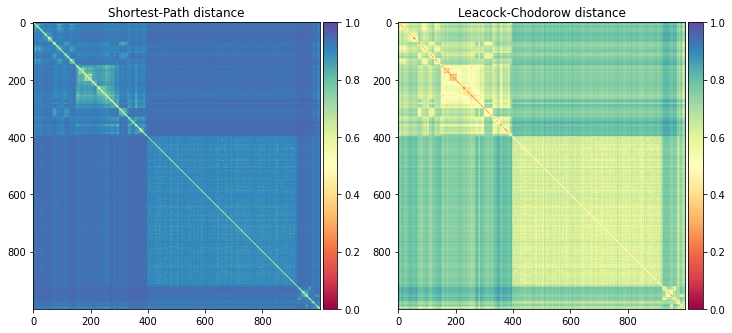

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

a = ax[0].imshow(D_imgnt[:, :, 0], vmin = 0, vmax = 1, cmap = 'Spectral')
ax[0].set_title("Shortest-Path distance")

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(a, cax=cax, orientation='vertical')

b = ax[1].imshow(D_imgnt[:, :, 1], vmin = 0, vmax = 1, cmap = 'Spectral')
ax[1].set_title("Leacock-Chodorow distance")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(b, cax=cax, orientation='vertical')

plt.show()

### CIFAR-100

For CIFAR-100 there is no natural connection to the WordNet synsets. So we did it manually.

In [5]:
# json file with ImageNet labels and their WordNet synsets
CIFAR100_FILE_PATH = '/content/CIFAR100_label_description.json'
    
cifar100_json_file = open(CIFAR100_FILE_PATH)
cifar100_json_str = cifar100_json_file.read()
cifar100_json_data = json.loads(cifar100_json_str)
cifar100_json_data = dict(itertools.islice(cifar100_json_data.items(), 100))

cifar_labels = list(cifar100_json_data.keys())

# computing distances between concepts and check is the matrix is symmetrical
D_cifar100 = torch.zeros([100, 100, 2])

for i, l_1 in tqdm(enumerate(cifar_labels)):
    for j, l_2 in enumerate(cifar_labels):
        s1 = wn.synset(cifar100_json_data[l_1]['name'])
        s2 = wn.synset(cifar100_json_data[l_2]['name'])
        
        D_cifar100[i,j, 0] = s1.path_similarity(s2)
        D_cifar100[j,i, 0] = s2.path_similarity(s1)

        assert D_cifar100[i,j, 0] == D_cifar100[j,i, 0]
        
        D_cifar100[i,j, 1] = s1.lch_similarity(s2)
        D_cifar100[j,i, 1] = s2.lch_similarity(s1)

        assert D_cifar100[i,j, 1] == D_cifar100[j,i, 1]

D_cifar100 = 1 - D_cifar100/torch.amax(D_cifar100, dim=(0, 1))

100it [00:07, 13.97it/s]


Visualising the semantic distances

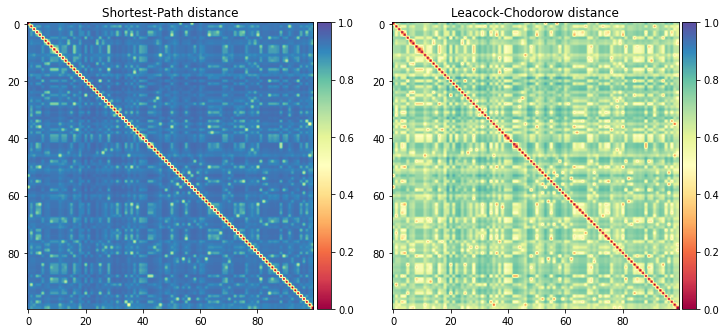

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

a = ax[0].imshow(D_cifar100[:, :, 0], vmin = 0, vmax = 1, cmap = 'Spectral')
ax[0].set_title("Shortest-Path distance")

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(a, cax=cax, orientation='vertical')

b = ax[1].imshow(D_cifar100[:, :, 1], vmin = 0, vmax = 1, cmap = 'Spectral')
ax[1].set_title("Leacock-Chodorow distance")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(b, cax=cax, orientation='vertical')

plt.show()

# 🪞 Alignment of EA and semantic distances

EA distance measure allows to estimate distances between neural representations. To evaluate the alignment of these distances with human judgement, we employ Mantel correlation test.

In [17]:
from skbio import DistanceMatrix
from skbio.stats.distance import mantel
from dora import EA_distance
import glob

metrics = ['Shortest-Path', 'Leacock-Chodorow']

def evaluate_alignment(sams_embeddings, D_sem, size = 1000):
    """
    Funtion that takes as an argument tensor of s-AMS embeddings in form of [k, k, n],
    computes EA distance and performs Mantel correlation test with ground truth

    sams_embeddings: torch.Tensor of shape [k, k, n], s-AMS embeddings
    D: torch.Tensor of shape [k, k, 2], semantic distance baseline
    """

    indeces = torch.triu_indices(size, size, offset = 0)
    out = torch.zeros([2, 2])
    
    # average across samples axis
    A = sams_embeddings.mean(axis = 2)

    D_l = DistanceMatrix(EA_distance(A, layerwise = True).numpy())
    D_p = DistanceMatrix(EA_distance(A, layerwise = False).numpy())

    for k in range(2):
      D_gt = DistanceMatrix(D_sem[:,:,k].numpy())
      out[0,k], p_val0, n = mantel(D_l, D_gt)
      print('l-w', metrics[k], round(float(out[0,k]), 2))
      out[1,k], p_val1, n = mantel(D_p, D_gt)
      print('p-w', metrics[k], round(float(out[1,k]), 2))

    return out          

### ImageNet experiment
We download the computed embeddings of the s-AMS for 8 different models

In [28]:
! rm -r imagenet

In [29]:
! wget -O imagenet_sAMS.zip https://www.dropbox.com/s/2n0f888ntzkl9z1/activations.zip
! mkdir imagenet
! unzip imagenet_sAMS.zip -d ./imagenet

--2023-02-27 23:32:17--  https://www.dropbox.com/s/2n0f888ntzkl9z1/activations.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/2n0f888ntzkl9z1/activations.zip [following]
--2023-02-27 23:32:17--  https://www.dropbox.com/s/raw/2n0f888ntzkl9z1/activations.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2ee7ac78a92d36420583181787.dl.dropboxusercontent.com/cd/0/inline/B3W-SfxZ4tc_vB3QYokbV4RBk2I1fIJh0pyb7Dl40ws1zv4NAJW3qFuDmarBcP01dY05EcDiwHG9lQQKsyl38KFRaipsmJvml7voscrSNj5rEVxsNKaOO9FQX5NfI6xCbJORTv-8s9NtFCMxSnJybs0xJ4i_N7kZ5BMeu8zcQj1BrA/file# [following]
--2023-02-27 23:32:17--  https://uc2ee7ac78a92d36420583181787.dl.dropboxusercontent.com/cd/0/inline/B3W-SfxZ4tc_vB3QYokbV4RBk2I1fIJh0pyb7Dl40ws1zv4NAJW3qFuDmarBcP01dY05EcD

In [30]:
all_paths = glob.glob("/content/imagenet/activations/*.tnsr")

for path in all_paths:
    name = path.split('/')[-1].split('.')[1]
    A = torch.load(path)
    
    print(name)
    result = evaluate_alignment(A, D_imgnt, size = 1000)

beit_base_patch16_224
l-w Shortest-Path 0.5
p-w Shortest-Path 0.43
l-w Leacock-Chodorow 0.48
p-w Leacock-Chodorow 0.39
shufflenet_v2_x1_0
l-w Shortest-Path 0.14
p-w Shortest-Path 0.21
l-w Leacock-Chodorow 0.1
p-w Leacock-Chodorow 0.17
densenet161
l-w Shortest-Path 0.44
p-w Shortest-Path 0.37
l-w Leacock-Chodorow 0.4
p-w Leacock-Chodorow 0.32
alexnet
l-w Shortest-Path 0.51
p-w Shortest-Path 0.48
l-w Leacock-Chodorow 0.52
p-w Leacock-Chodorow 0.46
inception_v3
l-w Shortest-Path 0.27
p-w Shortest-Path 0.24
l-w Leacock-Chodorow 0.23
p-w Leacock-Chodorow 0.2
vit_base_patch16_224
l-w Shortest-Path 0.53
p-w Shortest-Path 0.5
l-w Leacock-Chodorow 0.55
p-w Leacock-Chodorow 0.49
resnet18
l-w Shortest-Path 0.56
p-w Shortest-Path 0.44
l-w Leacock-Chodorow 0.53
p-w Leacock-Chodorow 0.4
mobilenet_v2
l-w Shortest-Path 0.59
p-w Shortest-Path 0.47
l-w Leacock-Chodorow 0.58
p-w Leacock-Chodorow 0.43


### CIFAR-100 experiment

In [8]:
! wget -O cifar100_activations.zip https://www.dropbox.com/s/chkab8w94irjdq5/cifar100_activations.zip
! mkdir cifar100
! unzip cifar100_activations.zip -d ./cifar100

--2023-02-27 22:38:57--  https://www.dropbox.com/s/chkab8w94irjdq5/cifar100_activations.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/chkab8w94irjdq5/cifar100_activations.zip [following]
--2023-02-27 22:38:57--  https://www.dropbox.com/s/raw/chkab8w94irjdq5/cifar100_activations.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc554e3a0325400fe4a8d2602bb4.dl.dropboxusercontent.com/cd/0/inline/B3Uwyv1q3_-vL7dG9KVCHxhtnqp-aT0p6jeyzhnqV9ompIFFP_BElHn4ZcoMdfGTt04T3wGBi4c5gbOnnY8_x9X9l_bYytgj47jbv3LkCIk3p88dGU6AObD8xkTEdkpZyZvhcEv9BXnQwNKZSDBmu5QmS8FR1PL9JLgPKbmkObc8oQ/file# [following]
--2023-02-27 22:38:58--  https://uc554e3a0325400fe4a8d2602bb4.dl.dropboxusercontent.com/cd/0/inline/B3Uwyv1q3_-vL7dG9KVCHxhtnqp-aT0p6jeyzhnqV9om

In [18]:
all_paths = glob.glob("/content/cifar100/activations/*.tnsr")

for path in all_paths:
    name = path.split('/')[-1].split('.')[1]
    A = torch.load(path)
    
    print(name)
    result = evaluate_alignment(A, D_cifar100, size = 100)

squeezenet
l-w Shortest-Path 0.51
p-w Shortest-Path 0.48
l-w Leacock-Chodorow 0.51
p-w Leacock-Chodorow 0.46
shufflenet
l-w Shortest-Path 0.49
p-w Shortest-Path 0.46
l-w Leacock-Chodorow 0.49
p-w Leacock-Chodorow 0.45
vgg11_bn
l-w Shortest-Path 0.27
p-w Shortest-Path 0.26
l-w Leacock-Chodorow 0.26
p-w Leacock-Chodorow 0.25
mobilenetv2
l-w Shortest-Path 0.44
p-w Shortest-Path 0.42
l-w Leacock-Chodorow 0.44
p-w Leacock-Chodorow 0.41
nasnet
l-w Shortest-Path 0.41
p-w Shortest-Path 0.39
l-w Leacock-Chodorow 0.42
p-w Leacock-Chodorow 0.38
resnet18
l-w Shortest-Path 0.39
p-w Shortest-Path 0.33
l-w Leacock-Chodorow 0.39
p-w Leacock-Chodorow 0.32
shufflenetv2
l-w Shortest-Path 0.5
p-w Shortest-Path 0.47
l-w Leacock-Chodorow 0.5
p-w Leacock-Chodorow 0.45
resnet9
l-w Shortest-Path 0.34
p-w Shortest-Path 0.33
l-w Leacock-Chodorow 0.32
p-w Leacock-Chodorow 0.3
